# _Trial 28_

__July 10, 2019__

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fastai libraries
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

In [3]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

# _Load in Data_

In [5]:
from test_folder import sample

In [6]:
train_df, valid_df = sample.prep_data(path);

Read in training and validation data sets
------------------------------
Added column to both data sets that indicates if observation is part of validation set or not.
------------------------------
Extracted patient ID and study number for each observation and assigned into new columns.
------------------------------
Filled in NaNs within pathology columns with 0 (see Stanford ML Github for further information on dealing with NaNs).
------------------------------
Converted pathology columns to integer type.
------------------------------
Pre-replacement Label Distribution: Label 0 = 188327, Label 1 = 27000, Label -1 = 8087
------------------------------
Replaced uncertain labels in Cardiomegaly column with 0 (i.e. negative)
Post-replacement Label Distribution: Label 0 = 196414, Label 1 = 27000
Does number of post-replacement 0 labels equal the sum of pre-replacement -1s and 0s? True
Returned training and validation data sets as pandas dataframes.


In [7]:
# set seed to help with reproducibility
sample.set_seed(1)

In [8]:
full_df = sample.oversample_and_prep(train_df, valid_df);

Created two new data sets, one with positive observations and the other with the negatives.
The shape of dataframe containing 0 (negative) labels: (196414, 22)
The shape of dataframe containing 1 (positive) labels: (27000, 22)
------------------------------
Random over-sampling: 
1    196414
0    196414
Name: Cardiomegaly, dtype: int64
------------------------------
Sampled from over-sampled dataframe.
Value Counts for Cardiomegaly column in new dataframe: 
1    98338
0    98076
Name: Cardiomegaly, dtype: int64
------------------------------
Concatenated oversampled training data set with validation data.
Returning full data set.


In [9]:
full_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,patient,study
0,CheXpert-v1.0-small/train/patient29646/study2/...,Male,37,Frontal,AP,0,0,0,-1,0,1,1,0,-1,0,1,0,0,0,False,patient29646,study2
1,CheXpert-v1.0-small/train/patient07979/study17...,Female,51,Frontal,AP,0,0,0,1,0,1,0,0,0,0,1,0,0,1,False,patient07979,study17
2,CheXpert-v1.0-small/train/patient37584/study2/...,Male,55,Frontal,AP,0,1,1,1,0,1,-1,0,-1,0,1,0,0,-1,False,patient37584,study2
3,CheXpert-v1.0-small/train/patient04193/study4/...,Male,83,Frontal,AP,0,0,1,1,0,1,0,0,0,0,0,0,0,0,False,patient04193,study4
4,CheXpert-v1.0-small/train/patient26475/study1/...,Male,78,Frontal,AP,0,0,1,-1,0,0,1,0,0,0,0,0,0,1,False,patient26475,study1


# _Deep Learning Fast.ai Set Up_

In [10]:
from test_folder import replicate

src = replicate.get_src(full_df, path, feature_col='Cardiomegaly')

In [11]:
# use image size of 64
data = replicate.get_data(64, src)

using bs=16, have 7601MB of GPU RAM free.
------------------------------
Data ready.


# _Create DenseNet Model_

__First Round of Training__

In [12]:
learn = cnn_learner(data=data, base_arch=models.densenet121, metrics=[AUROC(), Precision(), Recall()],
                    pretrained=True, ps=0.5, bn_final=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-06
Min loss divided by 10: 1.58E-01


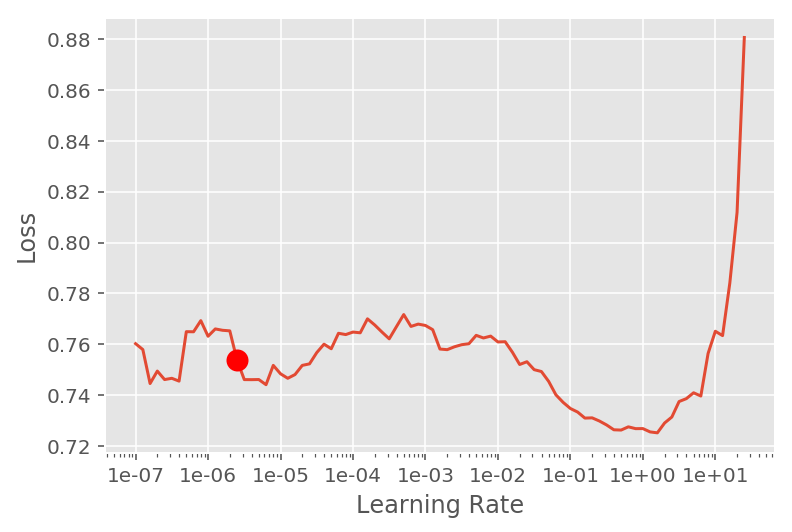

In [18]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn);

In [19]:
learn.fit_one_cycle(3, callbacks=
                    [SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_densenet121_trial28-rd1')])

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.520078,0.496561,0.790486,0.642857,0.397059,25:26
1,0.494891,0.461612,0.812721,0.730769,0.558824,25:21
2,0.504320,0.470743,0.804660,0.775000,0.455882,25:28


Better model found at epoch 0 with auroc value: 0.7904855012893677.
Better model found at epoch 1 with auroc value: 0.8127214908599854.


# _Train on Under-sampled data_

In [14]:
full_df_under = sample.undersample_and_prep(train_df, valid_df);

Created two new data sets, one with positive observations and the other with the negatives.
The shape of dataframe containing 0 (negative) labels: (196414, 22)
The shape of dataframe containing 1 (positive) labels: (27000, 22)
------------------------------
Random under-sampling: 
1    27000
0    27000
Name: Cardiomegaly, dtype: int64
------------------------------
Reshuffled rows in new undersampled dataframe.
------------------------------
Concatenated undersampled training data set with validation data.
Returning full data set.


In [15]:
src_under = replicate.get_src(full_df_under, path, feature_col='Cardiomegaly')

In [16]:
# use image size of 128 on undersampled data
data_under = replicate.get_data(128, src_under)

using bs=16, have 6407MB of GPU RAM free.
------------------------------
Data ready.


In [17]:
learn.data = data_under

In [18]:
learn.data

ImageDataBunch;

Train: LabelList (54000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,0,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

# _Second Round of Training w/ Undersampled Data Set_

In [19]:
learn.load('best_densenet121_trial28-rd1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.17E-05
Min loss divided by 10: 1.07E-02


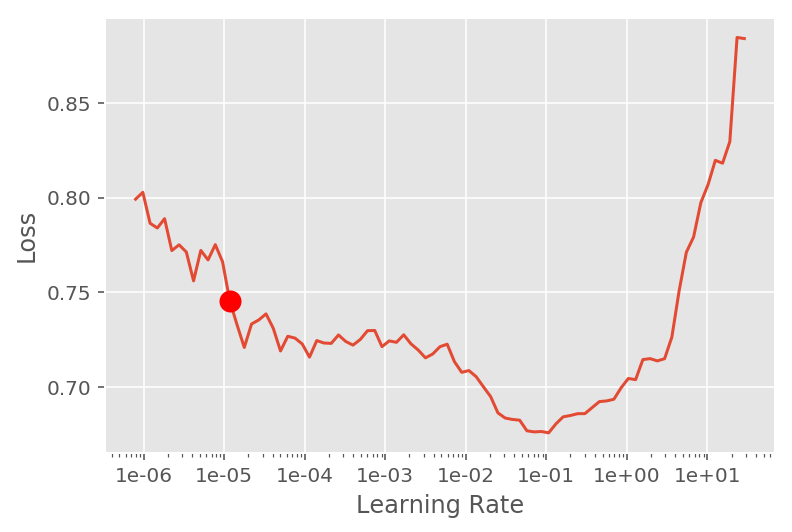

In [22]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn);

In [24]:
learn.fit_one_cycle(3, 3e-2, callbacks=
                    [SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_densenet121_trial28-rd2')])

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.551144,0.478980,0.788625,0.658537,0.397059,07:41
1,0.544296,0.514954,0.768161,0.620690,0.529412,07:45
2,0.502165,0.463499,0.811570,0.727273,0.470588,07:45


Better model found at epoch 0 with auroc value: 0.7886250615119934.
Better model found at epoch 2 with auroc value: 0.8115698099136353.


# _Increase Image Size to 256_

__Third Round of Training__

In [25]:
# use image size of 256 on undersampled data
data_under_256 = replicate.get_data(256, src_under)

using bs=16, have 5779MB of GPU RAM free.
------------------------------
Data ready.


In [26]:
learn.data = data_under_256

In [27]:
learn.data

ImageDataBunch;

Train: LabelList (54000 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,0,0,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [30]:
learn.load('best_densenet121_trial28-rd2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-07
Min loss divided by 10: 2.45E-02


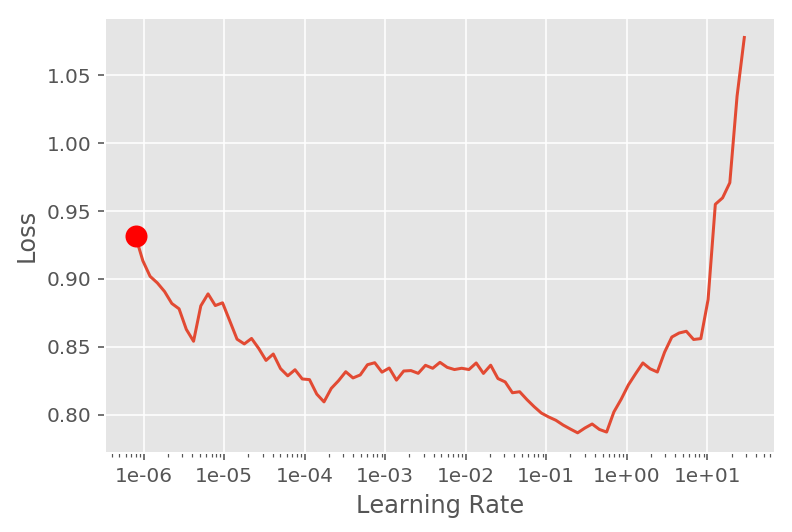

In [31]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn);

In [32]:
learn.fit_one_cycle(3, callbacks=
                    [SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_densenet121_trial28-rd3')])

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.559881,0.486426,0.815025,0.625000,0.514706,13:17
1,0.532328,0.473820,0.815556,0.634615,0.485294,13:18
2,0.549346,0.466740,0.816265,0.638298,0.441176,13:17


Better model found at epoch 0 with auroc value: 0.8150247931480408.
Better model found at epoch 1 with auroc value: 0.8155562877655029.
Better model found at epoch 2 with auroc value: 0.8162649869918823.


# _Increase Image Size to 320_

__Fourth Round of Training__

In [16]:
# use image size of 320 on undersampled data
data_under_320 = replicate.get_data(320, src_under)

using bs=16, have 7110MB of GPU RAM free.
------------------------------
Data ready.


In [17]:
learn.data = data_under_320

In [18]:
learn.data

ImageDataBunch;

Train: LabelList (54000 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,0,1,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (234 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
1,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: None

In [21]:
learn.load('best_densenet121_trial28-rd3');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-07
Min loss divided by 10: 1.20E-07


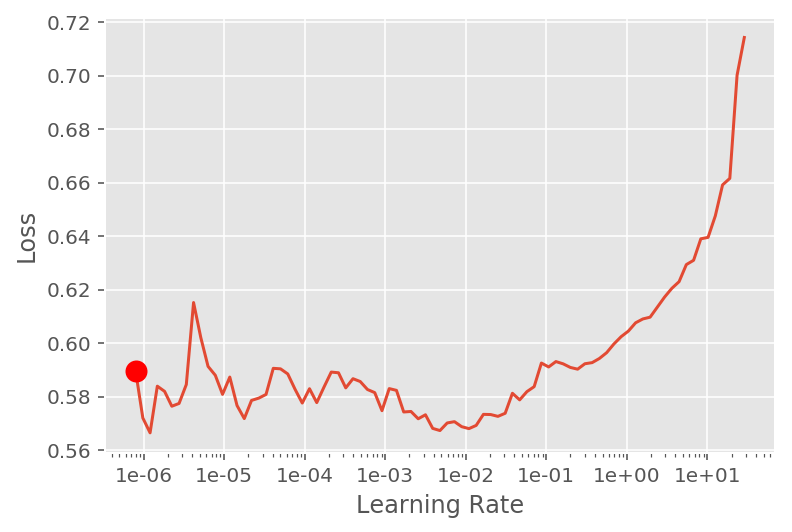

In [22]:
from test_folder import deeplearning

deeplearning.lr_finder_plot(learn);

In [23]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.48E-06
Min loss divided by 10: 1.15E-05


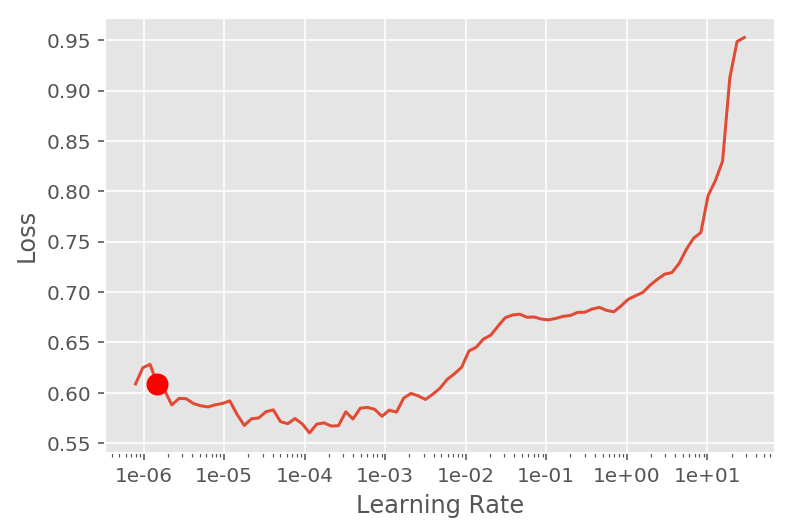

In [24]:
deeplearning.lr_finder_plot(learn);

In [25]:
# default learning rate for fit_one_cylce is 0.003
lr = learn.recorder.min_grad_lr
lr

1.4791083881682075e-06

In [26]:
learn.fit_one_cycle(3, slice(lr, lr/5), callbacks=
                    [SaveModelCallback(learn, every='improvement', monitor='auroc', name='best_densenet121_trial28-rd4')])

epoch,train_loss,valid_loss,auroc,precision,recall,time
0,0.573664,0.482050,0.816885,0.576271,0.500000,26:44
1,0.537132,0.471849,0.825833,0.551724,0.470588,26:14
2,0.544880,0.467106,0.826453,0.591837,0.426471,26:15


Better model found at epoch 0 with auroc value: 0.8168851733207703.
Better model found at epoch 1 with auroc value: 0.825832724571228.
Better model found at epoch 2 with auroc value: 0.826452910900116.


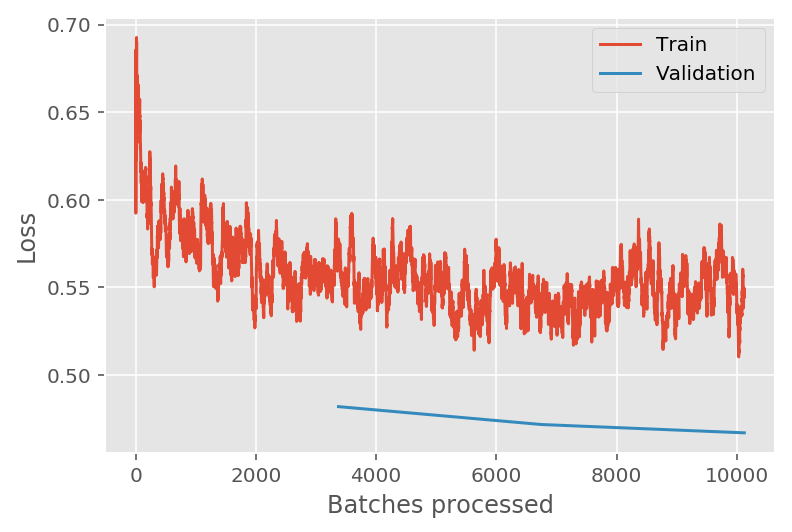

In [30]:
learn.recorder.plot_losses()

# _Interpret the Model_

In [34]:
learn.load('best_densenet121_trial28-rd4');

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

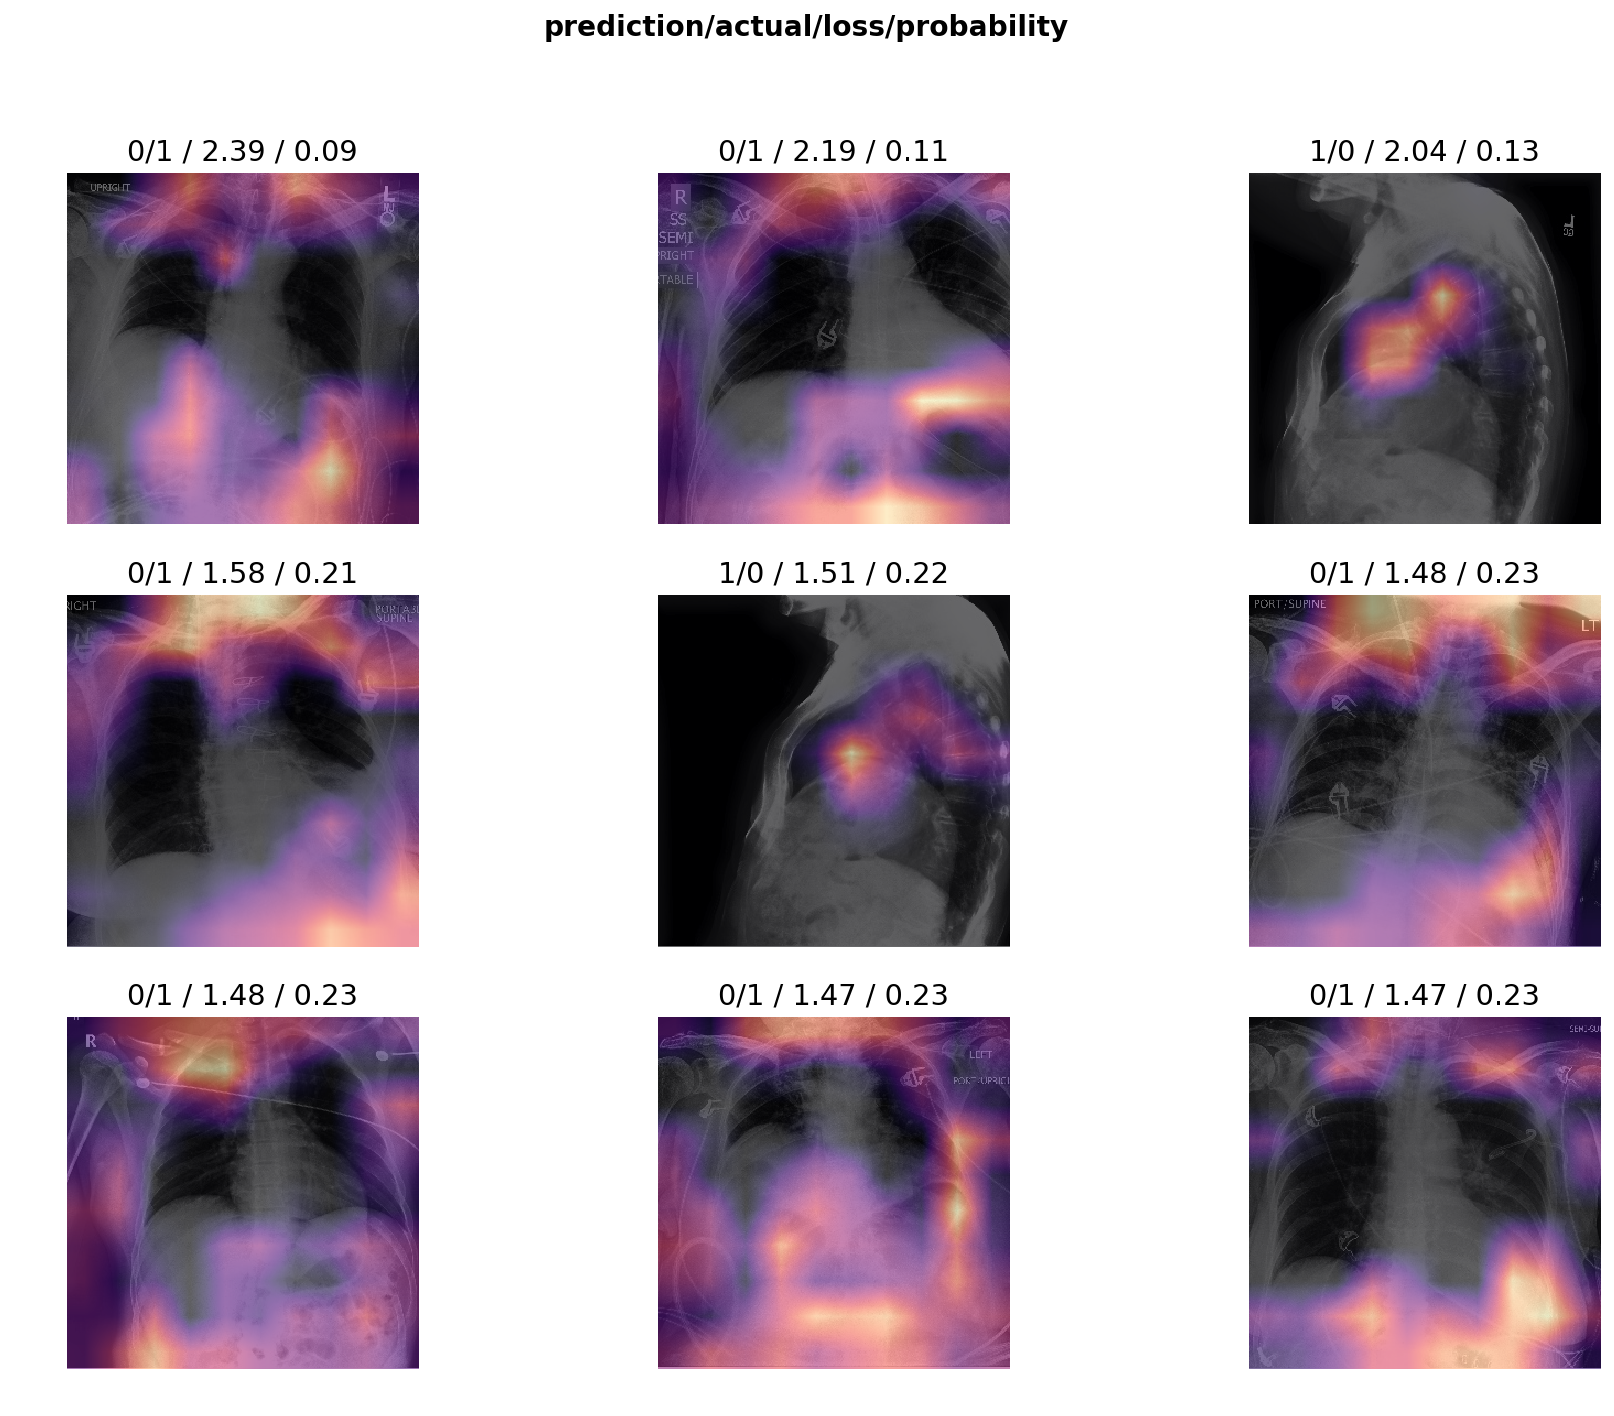

In [36]:
interp.plot_top_losses(9, figsize=(15,11))

In [37]:
interp.most_confused()

[(1, 0, 39), (0, 1, 20)]

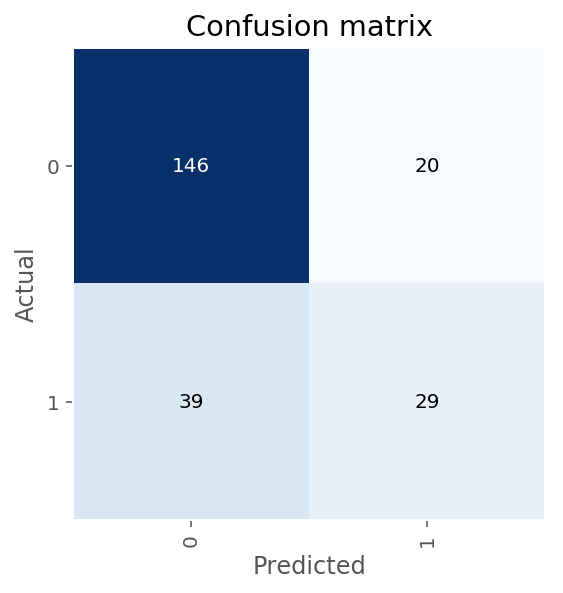

In [38]:
interp.plot_confusion_matrix()